# Predict Stock Prices

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random

In [22]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [23]:
def shuffle_unanimity(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

def data_load(ticker, n_steps=50, scale=True, 
              shuffle=True, step_lookup=1, 
              split_by_date=True,
              test_size=0.2, 
              features_column=['adjclose', 'volume', 'open', 'high', 'low']):
    
    """
    Loads data from Yahoo Finance source, also scaling, shuffling, normalizing and splitting.
    """
    
    # if ticker is already loaded 
    if isinstance(ticker, str):
        # load it 
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded
        df = ticker
    else:
        raise TypeError("ticker must be str or `pd.DataFrame` instances")
        
    # for all the elements to return from this function
    result = {}
    # the original dataframe 
    result['df'] = df.copy()
    
    # review if the passed features_column exist in the dataframe
    for col in features_column:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
        
    # add date 
    if "date" not in df.columns:
        df["date"] = df.index
        
    # scale the data (prices) from 0 to 1
    if scale:
        column_scaler = {}
        for column in features_column:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        result["column_scaler"] = column_scaler
        
    # add the target column (label) 
    df['future'] = df['adjclose'].shift(-step_lookup)
    
    # last `step_lookup` columns contains NaN in future column
    # get them before droping NaNs
    latest_sequence = np.array(df[features_column].tail(step_lookup))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    
    for entry, target in zip(df[features_column + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
            
    # get the last sequence 
    latest_sequence = list([s[:len(features_column)] for s in sequences]) + list(latest_sequence)
    latest_sequence = np.array(latest_sequence).astype(np.float32)
    result['latest_sequence'] = latest_sequence
    
    # Define and construct X,y
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # split the dataset 
    if split_by_date:
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        
        # shuffle the datasets 
        if shuffle:
            shuffle_unanimity(result["X_train"], result["y_train"])
            shuffle_unanimity(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        (result["X_train"], 
         result["X_test"], 
         result["y_train"], 
         result["y_test"]) = train_test_split(X, y, 
                                              test_size = test_size, 
                                              shuffle = shuffle)
        
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(features_column)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(features_column)].astype(np.float32)
    return result

In [25]:
# Construct the model
def build_model(sequence_length, n_features, units=256, 
                cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", 
                bidirectional=False):
    
    model = Sequential()
    
    for i in range(n_layers):
        
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), 
                                        batch_input_shape = (None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences = True, 
                               batch_input_shape = (None, sequence_length, n_features)))
                
        elif i == n_layers - 1:
            
            # latest layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
                
        else:
            
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
                
        # add dropout for every layer
        model.add(Dropout(dropout))
        
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [26]:
# Set parameters
import os
import time
from tensorflow.keras.layers import LSTM

# Window size or the sequence length
N_STEPS = 50
# Lookup step, 1 is the next day
step_lookup = 15
# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# whether to shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
# whether to split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
features_column = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 2
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False

### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 500

# Amazon stock market
ticker = "AMZN"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")

# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{step_lookup}-layers-{N_LAYERS}-units-{UNITS}"

if BIDIRECTIONAL:
    model_name += "-b"

In [27]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
    
if not os.path.isdir("logs"):
    os.mkdir("logs")
    
if not os.path.isdir("data"):
    os.mkdir("data")

In [28]:
# load the data
data = data_load(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, step_lookup=step_lookup, test_size=TEST_SIZE, 
                features_column=features_column)

# save the dataframe
data["df"].to_csv(ticker_data_filename)

# construct the model
model = build_model(N_STEPS, len(features_column), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

# train the model and save the weights 
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Train on 4858 samples, validate on 1215 samples
Epoch 1/500
4736/4858 [============================>.] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.0232
Epoch 00001: val_loss improved from inf to 0.00022, saving model to results\2021-10-03_AMZN-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
4858/4858 [==============================] - 8s 2ms/sample - loss: 0.0015 - mean_absolute_error: 0.0229 - val_loss: 2.1879e-04 - val_mean_absolute_error: 0.0124
Epoch 2/500
4800/4858 [============================>.] - ETA: 0s - loss: 4.7949e-04 - mean_absolute_error: 0.0151
Epoch 00002: val_loss did not improve from 0.00022
4858/4858 [==============================] - 2s 472us/sample - loss: 4.8152e-04 - mean_absolute_error: 0.0151 - val_loss: 3.3899e-04 - val_mean_absolute_error: 0.0135
Epoch 3/500
4800/4858 [============================>.] - ETA: 0s - loss: 5.1175e-04 - mean_absolute_error: 0.0150
Epoch 00003: val_loss improved from 0.00022 to 0.00015, saving model 

In [ ]:
!tensorboard --logdir="logs"

In [29]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    
    """
    Plots true close price along with predicted close price
    """
    plt.plot(test_df[f'true_adjclose_{step_lookup}'], c='b')
    plt.plot(test_df[f'adjclose_{step_lookup}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [30]:
def get_final_df(model, data):
    
    """
    This function takes the 'model' and 'data' dict to 
    construct a final dataframe that includes the features along 
    with true and predicted prices of the testing dataset
    """
    
    # Calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    
    # Subtract the true future price from the current price
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    
    # Perform prediction and get prices
    y_pred = model.predict(X_test)
    
    # Inverting the scaling
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
        
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{step_lookup}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{step_lookup}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{step_lookup}"], 
                                    final_df[f"true_adjclose_{step_lookup}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{step_lookup}"], 
                                    final_df[f"true_adjclose_{step_lookup}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return final_df

In [31]:
def predict(model, data):
    
    # Retrieve the latest sequence from data
    latest_sequence = data["latest_sequence"][-N_STEPS:]
    # expand dimension
    latest_sequence = np.expand_dims(latest_sequence, axis=0)
    # Get the prediction 
    prediction = model.predict(latest_sequence)
    
    # Get the price 
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
        
    return predicted_price

In [32]:
# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [33]:
# Evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)

# Calculate the mean absolute error 
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [34]:
# Get the final dataframe for the testing set
final_df = get_final_df(model, data)

In [35]:
# Predict the future price
future_price = predict(model, data)

In [36]:
# Calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + 
                  len(final_df[final_df['buy_profit'] > 0])) / len(final_df)

# Calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()

# Total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit

# Dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [37]:
# Printing metrics
print(f"Future price after {step_lookup} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 15 days is 3369.21$
huber_loss loss: 0.00010360660064494076
Mean Absolute Error: 26.52451347244058
Accuracy score: 0.4962962962962963
Total buy profit: 11397.97436618805
Total sell profit: 694.4719367027278
Total profit: 12092.446302890778
Profit per trade: 9.952630701967719


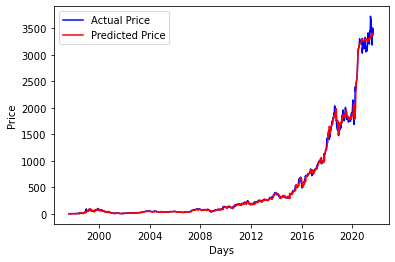

In [38]:
# plot true/pred prices graph
plot_graph(final_df)

In [39]:
print(final_df.tail(10))

# save the final dataframe to csv-results folder
csv_results_folder = "csv-results"

if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
    
csv_filename = os.path.join(csv_results_folder, model_name + ".csv")
final_df.to_csv(csv_filename)

                   open         high          low        close     adjclose  \
2021-07-16  3633.310059  3646.060059  3570.459961  3573.629883  3573.629883   
2021-07-19  3532.580078  3550.209961  3499.159912  3549.590088  3549.590088   
2021-07-22  3587.229980  3640.020020  3582.270020  3638.030029  3638.030029   
2021-07-23  3640.000000  3666.110107  3622.040039  3656.639893  3656.639893   
2021-07-29  3627.750000  3637.949951  3580.010010  3599.919922  3599.919922   
2021-08-05  3356.219971  3389.000000  3340.919922  3375.989990  3375.989990   
2021-08-16  3283.000000  3300.000000  3211.129883  3298.989990  3298.989990   
2021-08-20  3203.870117  3207.810059  3175.760010  3199.949951  3199.949951   
2021-08-23  3211.899902  3280.899902  3210.010010  3265.870117  3265.870117   
2021-09-03  3452.000000  3482.669922  3436.439941  3478.050049  3478.050049   

             volume ticker  adjclose_15  true_adjclose_15  buy_profit  \
2021-07-16  4043700   AMZN  3391.062988       3344.939941